In [1]:
!pip install astroNN
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00


In [18]:
from astroNN.datasets import load_galaxy10sdss
from tensorflow.keras import utils

# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10sdss()

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)


/root/.astroNN/datasets/Galaxy10.h5 was found!


In [9]:
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

Images shape:  (21785, 69, 69, 3)
Labels shape:  (21785, 10)


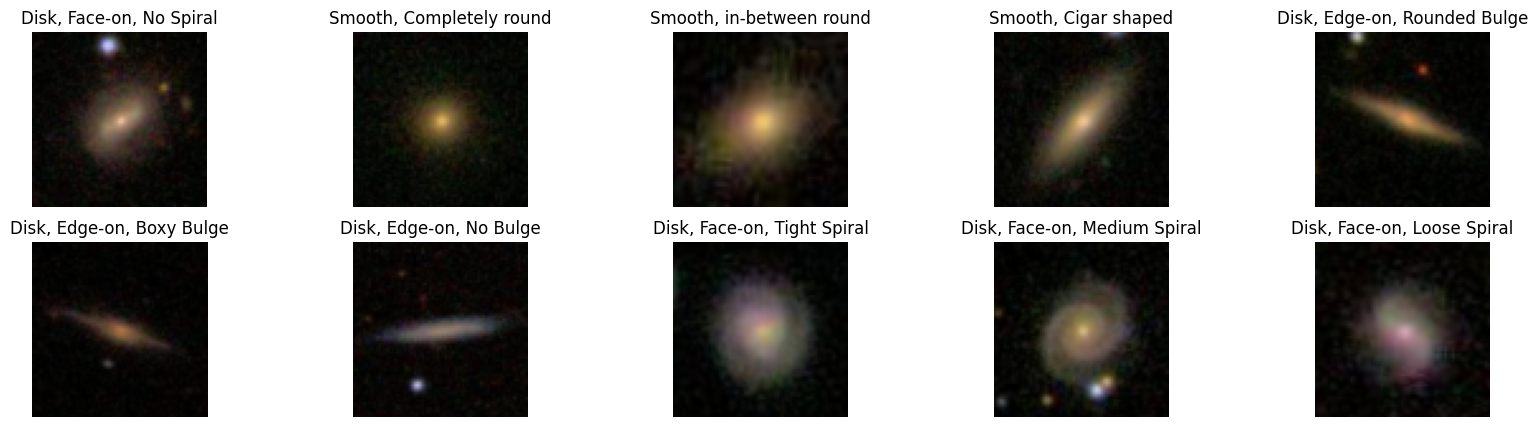

In [12]:
#Plot de 10 images
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import numpy as np

dict_de_galaxy10cls_traduzido_portugues = {
    0: "Disk, Face-on, No Spiral",
    1: "Smooth, Completely round",
    2: "Smooth, in-between round",
    3: "Smooth, Cigar shaped",
    4: "Disk, Edge-on, Rounded Bulge",
    5: "Disk, Edge-on, Boxy Bulge",
    6: "Disk, Edge-on, No Bulge",
    7: "Disk, Face-on, Tight Spiral",
    8: "Disk, Face-on, Medium Spiral",
    9: "Disk, Face-on, Loose Spiral"
}


def plot_images(images, labels, n=10):
    fig, axes = plt.subplots(2, n//2, figsize=(20, 5))
    for i in range(n):
        ax = axes[i//(n//2), i%(n//2)]
        ax.imshow(images[i], cmap=cm.Greys_r)
        ax.set_title(f"{dict_de_galaxy10cls_traduzido_portugues[np.argmax(labels[i])]}", fontsize=12)
        ax.axis('off')
    plt.show()

# Plot uma imagens aletória de cada classe
indices = []
for i in range(10):
    indices.append(random.choice(np.where(labels[:, i] == 1)[0]))


plot_images(images[indices], labels[indices], n=10)




In [19]:
#Remover a classe 5 inteira do dataset
images = np.delete(images, np.where(labels[:, 5] == 1), axis=0)
labels = np.delete(labels, np.where(labels[:, 5] == 1), axis=0)
#remover o label 5 de labels
labels = np.delete(labels, 5, axis=1)

#ver o shape
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)


Images shape:  (21768, 69, 69, 3)
Labels shape:  (21768, 9)


In [20]:



# =============================================================================
# 1) Importações gerais
# =============================================================================

import numpy as np
from tensorflow.keras import mixed_precision
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization
)
from sklearn.model_selection import train_test_split

# Limpa sessões anteriores e habilita XLA + mixed precision
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)          # XLA ON
mixed_precision.set_global_policy("mixed_float16")

# =============================================================================
# 2) Preparar os dados (assumindo que já existem arrays 'images' e 'labels')
# =============================================================================

# Normalizar pixels para [0,1] e dividir treino/teste
images_att = images.astype("float16") / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    images_att, labels,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print(f"Shape final de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape final de X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# =============================================================================
# 3) Construir o modelo “fixo” com os melhores hiperparâmetros
# =============================================================================

# Hiperparâmetros extraídos da imagem:
#    conv1_filters = 48
#    conv2_filters = 64
#    conv3_filters = 128
#    dropout_conv3  = 0.40
#    dense_units   = 128
#    dropout_fc    = 0.50
#    learning_rate = 0.001

def build_fixed_model(input_shape=(69, 69, 3),
                      conv1_filters=48,
                      conv2_filters=64,
                      conv3_filters=128,
                      dropout_conv3=0.40,
                      dense_units1=128,
                      dense_units2=64,
                      dropout_fc=0.50,
                      initial_lr=1e-3):
    model = keras.Sequential()

    # --- Bloco Conv1 ---
    model.add(Conv2D(conv1_filters, (3, 3), activation="relu", padding="same",
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # --- Bloco Conv2 ---
    model.add(Conv2D(conv2_filters, (3, 3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # --- Bloco Conv3 ---
    model.add(Conv2D(conv3_filters, (3, 3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Dropout fixo após o Conv3
    if dropout_conv3 > 0:
        model.add(Dropout(dropout_conv3))

    # --- Flatten + Dense ---
    model.add(Flatten())
    model.add(Dense(dense_units1, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_fc))
    model.add(Dense(dense_units2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_fc))

    # --- Camada de saída: 10 classes (você já removeu a classe antiga 5) ---
    model.add(Dense(9, activation="softmax"))

    # --- Otimizador AdamW com learning rate fixado em 0.001 e weight decay 1e-4 ---
    #    Aqui usamos AdamW, mas sem scheduler de decaimento, já que a imagem "fixou" lr em 0.001.
    optimizer = keras.optimizers.AdamW(learning_rate=initial_lr, weight_decay=1e-4)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instancia o modelo com parâmetros fixos
modelo = build_fixed_model(
    input_shape=(69, 69, 3),
    conv1_filters=48,
    conv2_filters=64,
    conv3_filters=128,
    dropout_conv3=0.40,
    dense_units1=128,
    dense_units2=64,
    dropout_fc=0.50,
    initial_lr=1e-3
)

modelo.summary()

# =============================================================================
# 4) Treinar o modelo “final” (sem tuner) – use EarlyStopping opcional se desejar
# =============================================================================

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = modelo.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1
)

# =============================================================================
# 5) Avaliar no conjunto de teste
# =============================================================================

loss_test, acc_test = modelo.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (modelo fixo):     {loss_test:.4f}")
print(f"Test Accuracy (modelo fixo): {acc_test:.4f}")

# =============================================================================
# 6) Salvar o modelo final
# =============================================================================

modelo.save("galaxy_model_final.h5")
print("Modelo salvo em 'galaxy_model_final.h5'")

del modelo
tf.keras.backend.clear_session()



Shape final de X_train: (18502, 69, 69, 3), y_train: (18502, 9)
Shape final de X_test:  (3266, 69, 69, 3),  y_test:  (3266, 9)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 69, 69, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 69, 69, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 34, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,162,185 (4.43 MB)

 Trainable params: 1,161,321 (4.43 MB)

 Non-trainable params: 864 (3.38 KB)

Epoch 1/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.2989 - loss: 2.3141 - val_accuracy: 0.3635 - val_loss: 2.0000
Epoch 2/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4883 - loss: 1.3482 - val_accuracy: 0.5562 - val_loss: 1.1160
Epoch 3/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5572 - loss: 1.1661 - val_accuracy: 0.5839 - val_loss: 1.1236
Epoch 4/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5972 - loss: 1.0673 - val_accuracy: 0.5285 - val_loss: 1.2392
Epoch 5/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6294 - loss: 0.9825 - val_accuracy: 0.6459 - val_loss: 0.9596
Epoch 6/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6530 - loss: 0.9230 - val_accuracy: 0.6733 - val_loss: 0.8924
Epoch 7/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6849 - loss: 0.8580 - val_accuracy: 0.6942 - val_loss: 0.8163
Epoch 8/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7139 - loss: 0.7859 - val_accuracy: 

Test Loss (modelo fixo):     0.5583
Test Accuracy (modelo fixo): 0.8120
Modelo salvo em 'galaxy_model_final.h5'


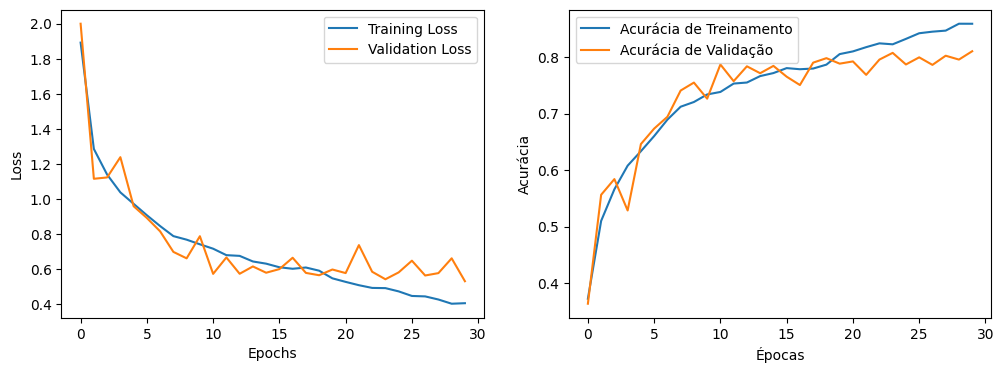

In [21]:
#plot do history
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    #
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    #
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.show()

plot_history(history)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
                              precision    recall  f1-score   support

    Disk, Face-on, No Spiral       0.62      0.62      0.62       517
    Smooth, Completely round       0.90      0.94      0.92      1010
    Smooth, in-between round       0.90      0.88      0.89       978
        Smooth, Cigar shaped       0.74      0.43      0.55        53
Disk, Edge-on, Rounded Bulge       0.86      0.86      0.86       232
     Disk, Edge-on, No Bulge       0.73      0.89      0.80        90
 Disk, Face-on, Tight Spiral       0.67      0.57      0.61       159
Disk, Face-on, Medium Spiral       0.52      0.61      0.56       146
 Disk, Face-on, Loose Spiral       0.69      0.46      0.55        81

                    accuracy                           0.81      3266
                   macro avg       0.74      0.70      0.71      3266
                weighted avg       0.81      0.81      0.81      3266



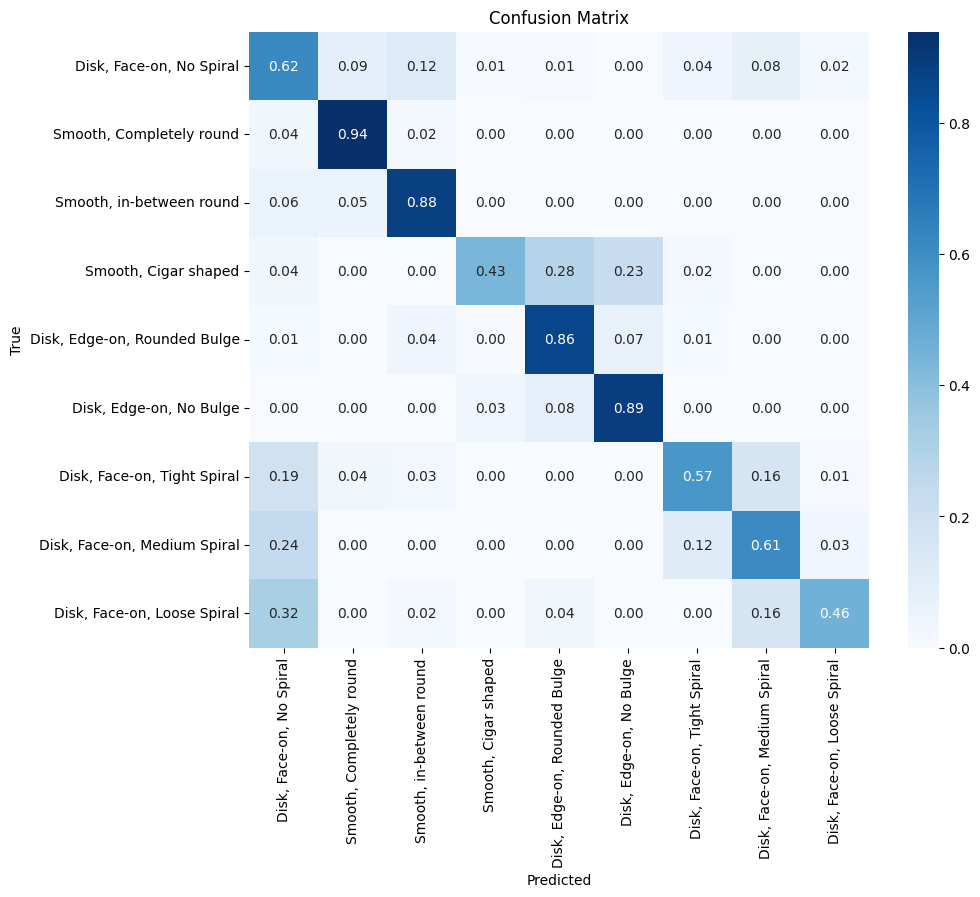

In [23]:
##load do modelo
from tensorflow.keras.models import load_model
modelo_otimizado = load_model('galaxy_model_final.h5')
dict_de_galaxy10cls_traduzido_portugues = {
    0: "Disk, Face-on, No Spiral",
    1: "Smooth, Completely round",
    2: "Smooth, in-between round",
    3: "Smooth, Cigar shaped",
    4: "Disk, Edge-on, Rounded Bulge",
    5: "Disk, Edge-on, No Bulge",
    6: "Disk, Face-on, Tight Spiral",
    7: "Disk, Face-on, Medium Spiral",
    8: "Disk, Face-on, Loose Spiral"
}
# fazer as métricas
y_pred = modelo_otimizado.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=list(dict_de_galaxy10cls_traduzido_portugues.values()))
    print(report)

print_classification_report(y_true_classes, y_pred_classes)

# plotar matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    # plot das porcentagens ao inves do número

    cm = confusion_matrix(y_true, y_pred, normalize= 'true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_de_galaxy10cls_traduzido_portugues.values()), yticklabels = list(dict_de_galaxy10cls_traduzido_portugues.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true_classes, y_pred_classes)

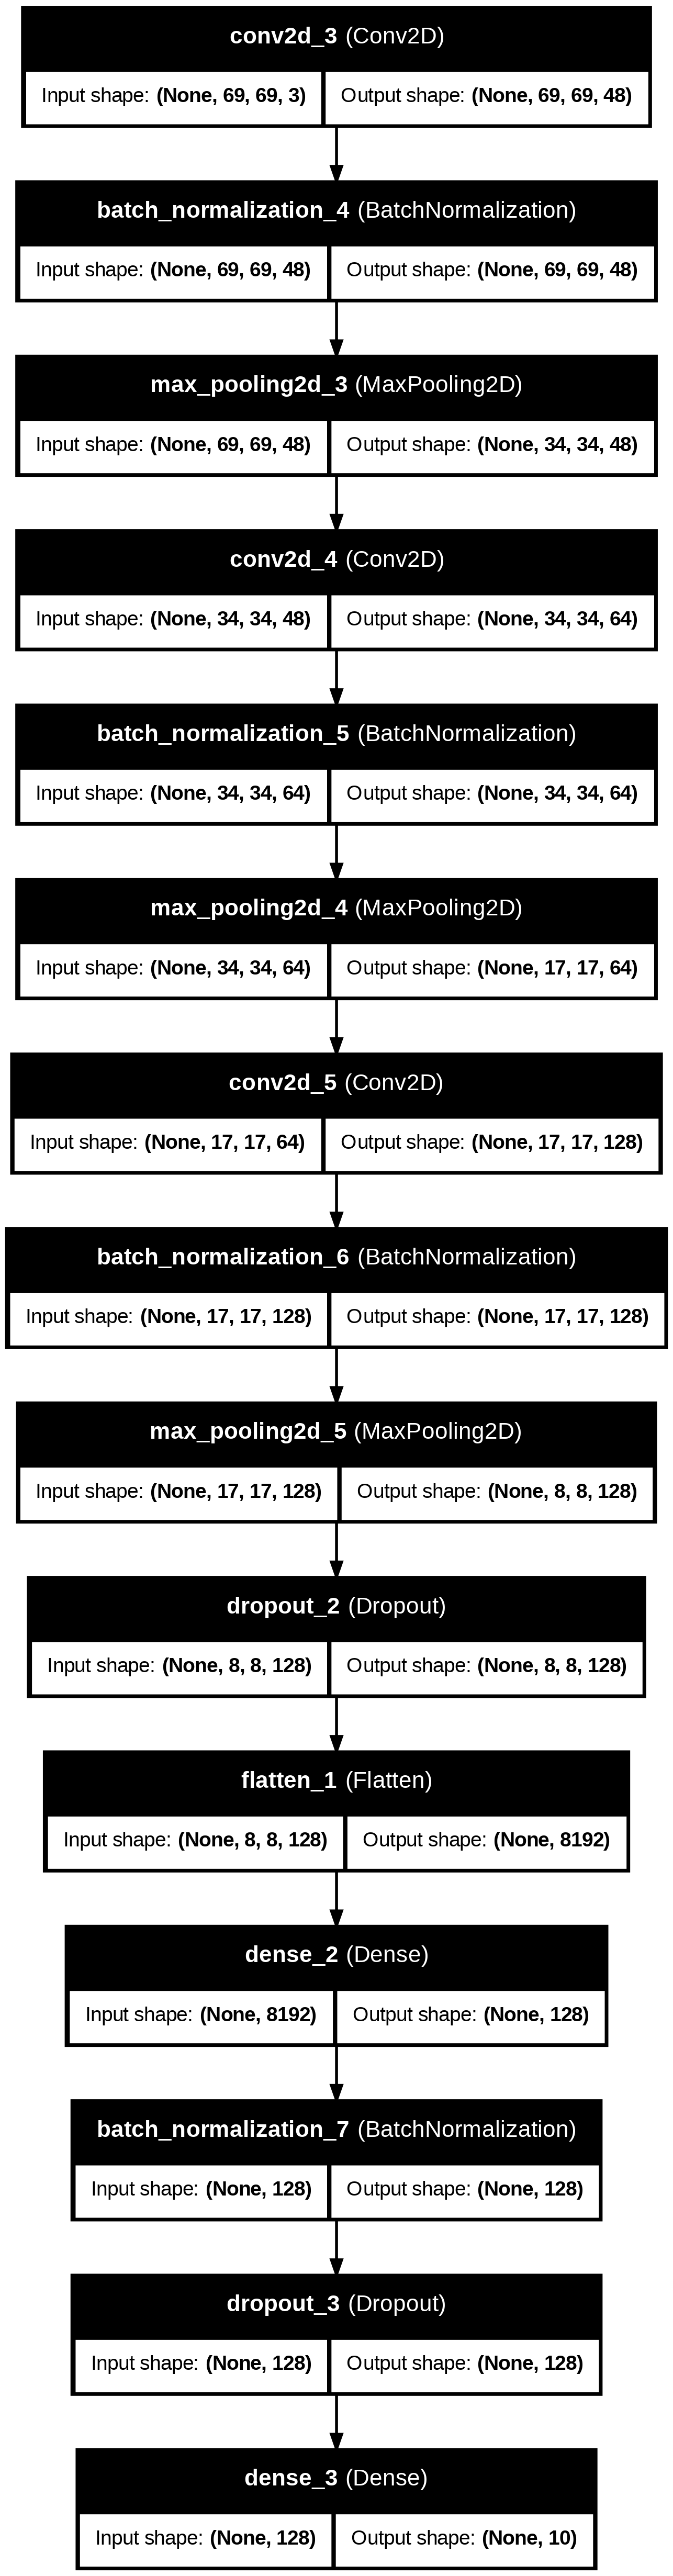

In [ ]:
##mostar o diagrama do modelo
from tensorflow.keras.utils import plot_model
plot_model(modelo_otimizado, to_file='modelo_otimizado.png', show_shapes=True, show_layer_names=True)

